# Heatmap/Scatterplot

This is basically another modification of the template file that we have used. Basically we just utilize a list of all the groupMetadataID's.
This means we can just run over a list for this and have the same process for the information that we extracted before.
Specifically, the mentors requested that we make a scatterplot/heatmap of the autonomous to manual transitions.

In [4]:
import plotly.express as px
from pandasgui import show
import pandas as pd

# Import plotly.express to utilize map

### List of groupMetadataID to show on the heatmap


In [5]:
gmIDs = pd.read_csv('./gmIDs.csv')
gmIDList = gmIDs['groupMetadataID']
print(len(gmIDList))
# set to False if data is stored as .csv file.
# otherwise, set to True
queryMetadata = True
queryPose = False
queryChassis = False

59


In [4]:
from boto3.dynamodb.conditions import Key, Attr
import boto3

if queryPose or queryChassis:
    # Get the service resource
    dynamodb = boto3.resource('dynamodb')
    # Instantiate a table resource object
    table = dynamodb.Table('ads_passenger_processed')

In [5]:
poseList = []
for gmID in gmIDList:
    if queryPose:
        # query for the bestPosData
        res = table.query(
            IndexName='topic-index',
            KeyConditionExpression=Key('topic').eq(
                '/apollo/sensor/gnss/best_pose'),
            ProjectionExpression="groupMetadataID, #t, solStatus, solType, latitudeStdDev, longitudeStdDev, heightStdDev, numSatsInSolution, differentialAge, solutionAge, latitude, longitude",
            Limit=1500,
            ExpressionAttributeNames={'#t': 'time'},
            FilterExpression=Key('groupMetadataID').eq(f'{gmID}')
    
        )
        df_pose = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        done = False
        leek = res["LastEvaluatedKey"]
        keywords = {
            "IndexName": 'topic-index',
            "KeyConditionExpression": Key('topic').eq(
                '/apollo/sensor/gnss/best_pose'),
            "ProjectionExpression": "groupMetadataID, #t, solStatus, solType, heightStdDev, numSatsInSolution, differentialAge, solutionAge, latitude, longitude, latitudeStdDev, longitudeStdDev",
            "Limit": 1500,
            "ExpressionAttributeNames": {'#t': 'time'},
            "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
        }
        while not done:
            try:
                leek = res["LastEvaluatedKey"]
                keywords["ExclusiveStartKey"] = leek
                res = table.query(**keywords)
                tmpDF = pd.DataFrame.from_dict(
                    pd.json_normalize(res['Items']), orient='columns')
                df_pose = pd.concat([df_pose, tmpDF])
            except KeyError:
                print(f"done querying for {gmID}")
                # df.to_csv(f"best_pose_58263e34-a45c-11ee-88ec-eb6a8d5269b4.csv")
                done = True
    
        s = "./pose30/best_pose_" + gmID + ".csv"
        df_pose.to_csv(s)

    df_pose = pd.read_csv(f"./pose30/best_pose_{gmID}.csv")
    poseList.append(df_pose)
print(len(poseList))
print(poseList[0].shape)

30
(245, 13)


In [6]:
#making a list of dataframes once we get all the csv read
chassisList = []
for gmID in gmIDList:
    if queryChassis:
        res = table.query(
            IndexName='topic-index',
            KeyConditionExpression=Key('topic').eq('/apollo/canbus/chassis'),
            Limit=1500,
            FilterExpression=Key('groupMetadataID').eq(gmID)
        )
        df = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        done = False
        leek = res["LastEvaluatedKey"]
        keywords = {
            "IndexName": 'topic-index',
            "KeyConditionExpression": Key('topic').eq('/apollo/canbus/chassis'),
            "Limit": 1500,
            "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
        }
        while not done:
            try:
                leek = res["LastEvaluatedKey"]
                keywords["ExclusiveStartKey"] = leek
                res = table.query(**keywords)
                tmpDF = pd.DataFrame.from_dict(
                    pd.json_normalize(res['Items']), orient='columns')
                df = pd.concat([df, tmpDF])
    
            except KeyError:
                print(f"done querying for {gmID}")
                done = True
    
        s = f"./chassis30/{gmID}.csv"
        df.to_csv(s)
    #read csv
    chassisFrame = pd.read_csv(f"./chassis30/{gmID}.csv")
    #append csv to the list
    chassisList.append(chassisFrame)
print(len(chassisList))
print(chassisList[0].shape)

30
(12180, 32)


In [7]:
for i in range(0, len(chassisList)):
    chassisList[i] = chassisList[i].sort_values('time')
    # reduce df to only time and drivingMode
    chassisList[i] = chassisList[i][["time", "drivingMode"]]
    # function to tell us what state transition it is
    
    
    def getState(old, new):
        if old == "COMPLETE_AUTO_DRIVE" and new == "COMPLETE_MANUAL":
            return "A->M"
        elif old == "COMPLETE_AUTO_DRIVE" and new == "EMERGENCY_MODE":
            return "A->M"
        elif old == "COMPLETE_MANUAL" and new == "COMPLETE_AUTO_DRIVE":
            return "M->A"
        elif old == "EMERGENCY_MODE" and new == "COMPLETE_AUTO_DRIVE":
            return "M->A"
        else:
            return "NONE"
    
    
    # we shift the drivingMode column down by 1
    chassisList[i]["shift"] = chassisList[i]["drivingMode"].shift()
    # create transition field
    chassisList[i]['transition'] = (chassisList[i]["drivingMode"] != chassisList[i]["shift"])
    # set Transition type to NONE for all
    chassisList[i]['transitionType'] = "NONE"
    # Set first transition to False, since it was auto True
    chassisList[i].loc[0, 'transition'] = False
    # print(pts['transition'])
    # Show counts for transitions
    #print(pts['transition'].value_counts())
    # iterate over all rows and find the ones where transition is true. Then we compare shift and dM to see what
    # transition Type we have.
    for index, row in chassisList[i].iterrows():
        if chassisList[i]['transition'][index] == True:
            old = chassisList[i]['shift'][index]
            new = chassisList[i]['drivingMode'][index]
            chassisList[i].loc[index, "transitionType"] = getState(old, new)
    #print(pts['transitionType'].value_counts())
    chassisList[i] = chassisList[i][['time', 'drivingMode', 'transition', 'transitionType']]
    chassisList[i] = chassisList[i].sort_values('time')
    chassisList[i]['time'] = chassisList[i]['time'].astype(float)
    chassisList[i]['time'] = chassisList[i]['time'].astype('datetime64[ns]')
    chassisList[i]['time'] = chassisList[i]['time'].astype('datetime64[s]')
    #print(chassisList[i][['time']])

In [8]:
finalDF = pd.DataFrame()
print(len(poseList))
for i in range(0,len(poseList)):
    bestPos = poseList[i].copy()
    bestPos = bestPos.sort_values('time')
    bestPos['time'] = bestPos['time'].astype(float)
    bestPos['time'] = bestPos['time'].astype('datetime64[ns]')
    bestPos['time'] = bestPos['time'].astype('datetime64[s]')
    bestPos = bestPos[['time', 'latitude', 'longitude']]
    #print(bestPos['time'])
    #print(chassisList[i]['time'])
    merged_df = pd.merge(chassisList[i], bestPos, on='time')
    merged_df = merged_df.drop_duplicates(subset = ['time', 'transitionType'])
    merged_df = merged_df[(merged_df['transitionType'] == 'A->M')]
    #remove all NONE transition columns
    finalDF = pd.concat([finalDF, merged_df])
#show(finalDF)

30


### Mapping


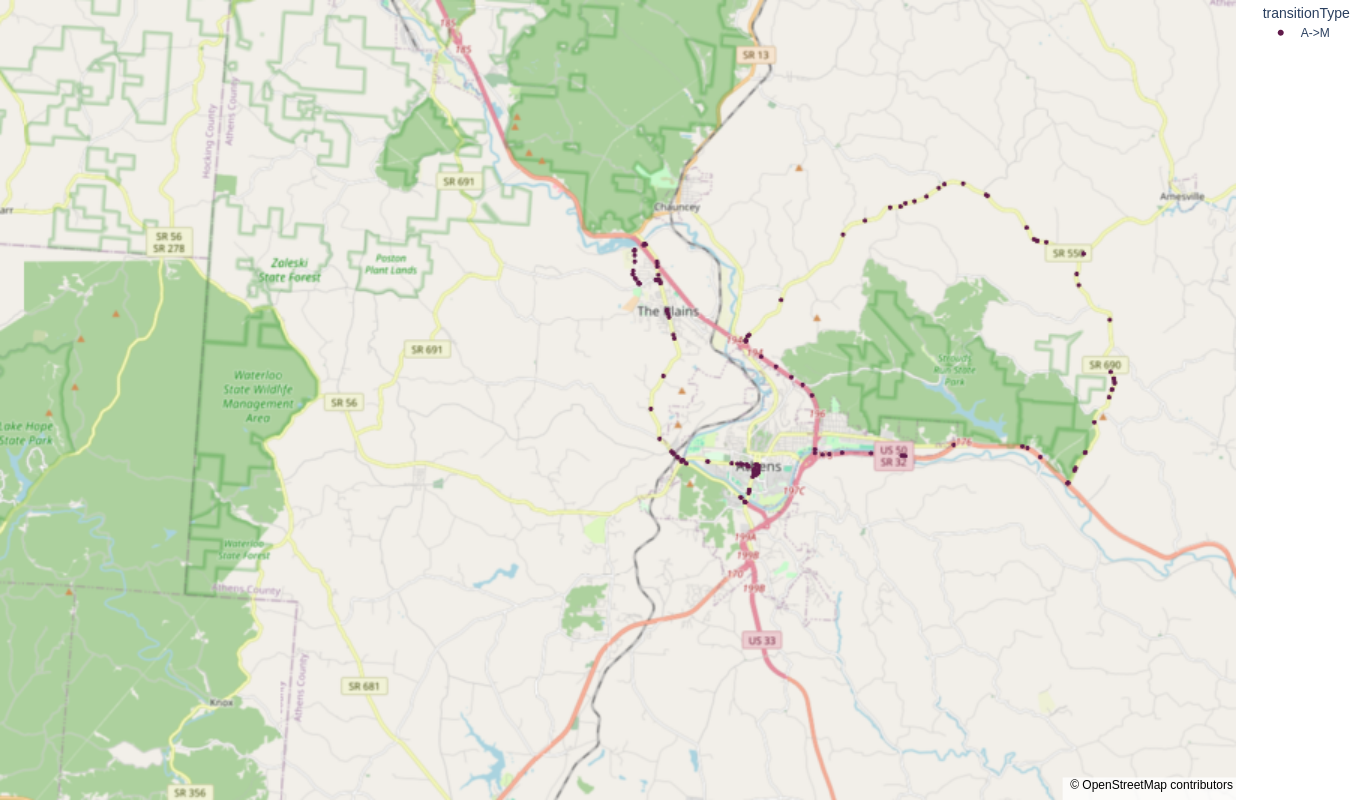

True

In [11]:
from dash import Dash, dcc, html
import webbrowser

# Define your map with your dataframe name first and keep everything else the same
fig = px.scatter_mapbox(finalDF, lat="latitude", lon="longitude",
                        hover_data=["time", "drivingMode", "transitionType"], color="transitionType", zoom=11, height=800, width=1200,
                        color_discrete_sequence=[
                            "#601A4A",
                            "#63ACBE",
                            "#EE442F",
                        ]
                        )

# Layout settings
fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
)

# Display the map
fig.show()
app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

# Turn off reloader if inside Jupyter
app.run_server(debug=True, use_reloader=False)
webbrowser.open('http://127.0.0.1:8050/', new=0)  # Go to example.com

In [13]:
fig.write_image("disengagementMap2.png", engine="kaleido")

In [ ]:
# Define your map with your dataframe name first and keep everything else the same
fig2 = px.scatter_mapbox(merged_df, lat="latitude",
                         lon="longitude",
                         hover_data=["time", "drivingMode", "transitionType"],
                         color="drivingMode",
                         zoom=14,
                         height=700,
                         width=1000,
                         color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         }

                         )

# Layout settings
fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

# Display the map
fig2.show()

In [34]:
from dash import Dash, dcc, html
import webbrowser

fig4 = px.scatter_mapbox(merged_df, lat="latitude",
                         lon="longitude",
                         hover_data=["time", "drivingMode", "transitionType"],
                         color="drivingMode",
                         zoom=14,
                         height=850,
                         width=1500,
                         color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         })

# Layout settings
fig4.update_layout(mapbox_style="open-street-map")
fig4.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig4)
])

# Turn off reloader if inside Jupyter
app.run_server(debug=True, use_reloader=False)
webbrowser.open('http://127.0.0.1:8050/', new=0)  # Go to example.com

True

### Plotting


In [30]:
fig3 = px.line(merged_df, x='time', y='drivingMode',
               title='Times at Which Transitions Occur')
fig3.update_xaxes(rangeslider_visible=True)
fig3.show()